<a href="https://colab.research.google.com/github/mouslimdiallo/src/blob/main/Identification_visage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Commençons notre projet. Nous allons utilisé un modèle préentrainé avec VGGFace combiné avec la biblio Keras_vggface. Nous aurons une base de données photographiques de célebrités où ferons ferons une extraction et une prédiction des visages.

- Import des bibliothèques
- Utilisation Git du modèle Keras_vggface existant
- Installation des outils
- Correction des erreurs
- Utilisation des tableaux et de la visualisation
- Utilisation des modèles vgg16 et senet50 ...
- Prétraitement et extraction
- Test et ouverture ... 
- References : Chap 29 Deep Learning for
Computer Vision - Jason Brownlee

In [2]:
# installation du modèle préentrainé keras et vggface avec le code source de l'auteur Refik Can MALLI
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-yvk6pjw6
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-yvk6pjw6
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=60cabd3ff8eb28491f1a744690a4a5f0666d13e3c17420c2d6a081a318e5fceb
  Stored in directory: /tmp/pip-ephem-wheel-cache-xql06s8k/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [7]:
#  Verification de l'installation
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: h5py, six, keras, pyyaml, pillow, scipy, numpy
Required-by: 


In [ ]:
# Installation de keras et ses applications tierces.
!pip install keras_applications

In [10]:
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace

vggface = VGGFace(model='resnet50') 
# or VGGFace() as default

165453824/165439116 [==============================] - 3s 0us/step


In [11]:
from keras.utils.layer_utils import get_source_inputs
# import des bibliothèques
import tensorflow.python.keras.engine
import keras_vggface
# La version
print(keras_vggface.__version__)

0.6


Pour la detection des visages, utilisons mtcnn

In [12]:
!pip install mtcnn
import mtcnn
# La version
print(mtcnn.__version__)


     |████████████████████████████████| 2.3 MB 5.3 MB/s 
0.1.0


Utilisons les tableaux numpy, le visuel plot pour charger les images dans les tableaux et redimensionner avec la biblio PIL

In [16]:
#import des bibliothèques pour cela
import numpy as np
import matplotlib.pyplot as plt
import PIL
from matplotlib import pyplot as plt

Nous voyons dans ce code, le chargeement de la photographie, extraction du visage et la tracée du résultat.

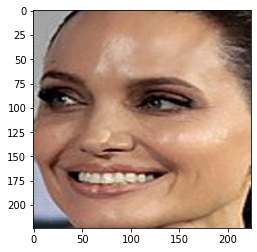

In [17]:
# Detection du visage à l'aide de mtcnn : import biblio
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
# extraction d'un seul visage dans notre photo
def extract_face(filename, required_size=(224, 224)):
  # charger l'image à partir du fichier
  pixels = pyplot.imread(filename)
  # créer le détecteur, en utilisant les poids par défaut
  detector = MTCNN()
  # detection du visage dans l'image
  results = detector.detect_faces(pixels)
  # extraire le cadre de délimitation de la première face
  x1, y1, width, height = results[0]['box']
  x2, y2 = x1 + width, y1 + height
  # extraction du visage
  face = pixels[y1:y2, x1:x2]
  # redimention des pixels 
  image = Image.fromarray(face)
  image = image.resize(required_size)
  face_array = asarray(image)
  return face_array

# Charger la photo et extraire le visage
pixels = extract_face('/content/Angelina.jpg')
# tracer le visage extrait
pyplot.imshow(pixels)
# montrer le visage extrait
pyplot.show()

Avec cette fonction face_extract, nous observons l'extraction d'un seul visage même s'il a plusieurs dans l'image. Nous l'utilisons pour la reconnaissance faciale avvec VGGface.[link text](https://)

Création d'un modele VGGFace pour l'identification

In [18]:
# exemple de création d'une intégration de visage
from keras_vggface.vggface import VGGFace
# creation d'un modele vggface2 preentrainé avec resnet50
model = VGGFace(model='resnet50')
# Definition de la Forme d'entrée et de sortie du modele
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_5')>]
Outputs: [<KerasTensor: shape=(None, 8631) dtype=float32 (created by layer 'classifier')>]


Constat du result : nous avons une entrée d'image 244 × 244 et une sortie de 8631 visages. Ce qui constitue notre base de données pour ce modèle.

Donc avec notre model.keras on peut faire une prédiction en comparant dans 8631 visages. Réajustons aussi les valeurs de pixels avant la prédiction.

In [19]:
# Detection du visage avec vggface2 model
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# extraire un seul visage dans la photo
def extract_face(filename, required_size=(224, 224)):
# chargement de l'image 
  pixels = pyplot.imread(filename)
  # creer le detecteur, using default weights
  detector = MTCNN()
  # detection du visage dans l'image
  results = detector.detect_faces(pixels)
  # # extraire le cadre de délimitation de la première face
  x1, y1, width, height = results[0]['box']
  x2, y2 = x1 + width, y1 + height
  # extracttion du visage
  face = pixels[y1:y2, x1:x2]
  # redimentionnment du pixel de l'image
  image = Image.fromarray(face)
  image = image.resize(required_size)

  face_array = asarray(image)
  return face_array

# charger la photo et extraire le visage
pixels = extract_face('/content/Dwayne.jpg')
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# creation du modele vggface preentrainé
model = VGGFace(model='resnet50')
# effectuer une prédiction
yhat = model.predict(samples)
# convertir la prédiction en noms
results = decode_predictions(yhat)
# affiche les résultats les plus probables
for result in results[0]:
  print('%s: %.3f%%' % (result[0][3:-1], result[1]*100))

1359872/1346516 [==============================] - 0s 0us/step
Dwayne_Johnson: 22.487%
Stone_Cold_Steve_Austin: 11.015%
Juan_Sebasti\xc3\xa1n_Ver\xc3\xb3n: 5.335%
Albert_Pujols: 4.156%
James_LaBrie: 3.990%


Et voici notre prédiction, avec l'affichage du nom et une précision de 95%. J'ai pris une image d'une celebrité sur wikipedia Drew Barrymore, 99.92%. commme suit # Drew_Barrymore: 99.928%
Amy_Fisher: 0.023%
Ekaterina_Vilkova: 0.010%
Gretchen_Mol: 0.003%
Faith_Prince: 0.003%

Un autre exemple avec l'acteur Dwayne Johnson, voici le resultat : Dwayne_Johnson: 99.818%

Constat : très efficaces pour les célébrités connues

Il y a aussi les modèles vgg16 et senet50 qu'on a pas utilisés. Comparer les modèles, ajouter un nouveau dataset et tester l'efficacité.

Avec VGGFace2, on va créer un modèle de prediction avec la fonction extract pour extraire les visages des photos (224x224 px). Même procédure qu'avant.

In [20]:
# Vérification faciale avec le modèle VGGface2
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# Extraire un seul visage d'une photo donnée
def extract_face(filename, required_size=(224, 224)):
    # chargement de l'image 
    pixels = pyplot.imread(filename)
    # creer le detecteur, using default weights
    detector = MTCNN()
    # detection du visage dans l'image
    results = detector.detect_faces(pixels)
    # # extraire le cadre de délimitation de la première face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extracttion du visage
    face = pixels[y1:y2, x1:x2]
    # redimentionnment du pixel de l'image
    image = Image.fromarray(face)
    image = image.resize(required_size)

    face_array = asarray(image)
    return face_array


# extraire les visages et calculer les intégrations de visages pour une liste de fichiers photo
def get_embeddings(filenames):
  # extraire les visages
  faces = [extract_face(f) for f in filenames]
  # convertir en un tableau d'échantillons
  samples = asarray(faces, 'float32')
  # préparer le visage pour le modèle, par exemple les pixels centraux
  samples = preprocess_input(samples, version=2)
  # créer un modèle vggface
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # effectuer une prédiction
  yhat = model.predict(samples)
  return yhat

# déterminer si un visage candidat correspond à un visage connu
def is_match(known_embedding, candidate_embedding, thresh=0.5):
  # calculer la distance entre les plongements
  score = cosine(known_embedding, candidate_embedding)
  if score <= thresh:
    print ('> Le visage a une correspondance de (%.3f <= %.3f)' % (score, thresh))
  else :
    print ('> Le visage n\'a pas de correspondance à (%.3f > %.3f)' % (score, thresh))

# définir les noms de fichiers
filenames = ['Jon1.jpg', 'Jon2.jpg', 'Jon3.jpg', 'drew.jpg']
 # obtenir les noms de fichiers des fichiers d'intégration
embeddings = get_embeddings(filenames)
 # définir la pierre de sharon
Jon_id = embeddings[0]
# vérifier les photos connues de sharon
print ( 'Tests Positifs')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# vérifier les photos connues d'autres personnes
print ("Tests négatifs")
is_match(embeddings[0], embeddings[3])

94707712/94694792 [==============================] - 1s 0us/step
Tests Positifs
> Le visage a une correspondance de (0.321 <= 0.500)
> Le visage a une correspondance de (0.332 <= 0.500)
Tests négatifs
> Le visage n'a pas de correspondance à (0.736 > 0.500)


Résumé : VGGFace et VGGFace2 pour la reconnaissance faciale.
- Installation de la biblio Keras_VGGFace
- Réalisation d'une prédiction avec un modèle préentrainé pour predire des visages des célébrités.
- Techniques de verification et identification du visage dans les photos.